## fastai is a library developed by jeremy howard(top kaggler for 2 yrs)...he basically implemented all the research <span class="girk">that is useful in practical context under this nice wrapper</span>(fastai)....his twitter account is a must follow..(a treasure trove of great research paper suggestions)

In [1]:
from fastai import *          # Quick accesss to most common functionality
from fastai.collab import *   # Quick accesss to collab filtering functionality

## for users of pytorch the following code is pretty readable...except maybe the weight initialization logic.....
## I have previously tried this approach for imdb dataset but without fastai..in pytorch(0.3) ... it works almost equally well but with out the benefit of - [superconvergance](https://arxiv.org/abs/1708.07120)..here i tried to give some explanation ....

In [ ]:
class EmbeddingDotBias(nn.Module):
    "Base model for callaborative filtering."
    def __init__(self, n_factors:int, n_users:int, n_items:int, min_score:float=None, max_score:float=None):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [get_embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.min_score is None: return res
        return torch.sigmoid(res) * (self.max_score-self.min_score) + self.min_score
    
    
def trunc_normal_(x:Tensor, mean:float=0., std:float=1.) -> Tensor:
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

def get_embedding(ni:int,nf:int) -> Model:
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb
    

In [5]:
%pwd

'/home/vinay/Downloads'

## HAVING A BIAS FOR EACH USER AND MOVIE IS VERY IMPORTANT WITHOUT THAT THE RESULTS WILL BE POOR WHICH INTUITIVELY MAKES SENSE.

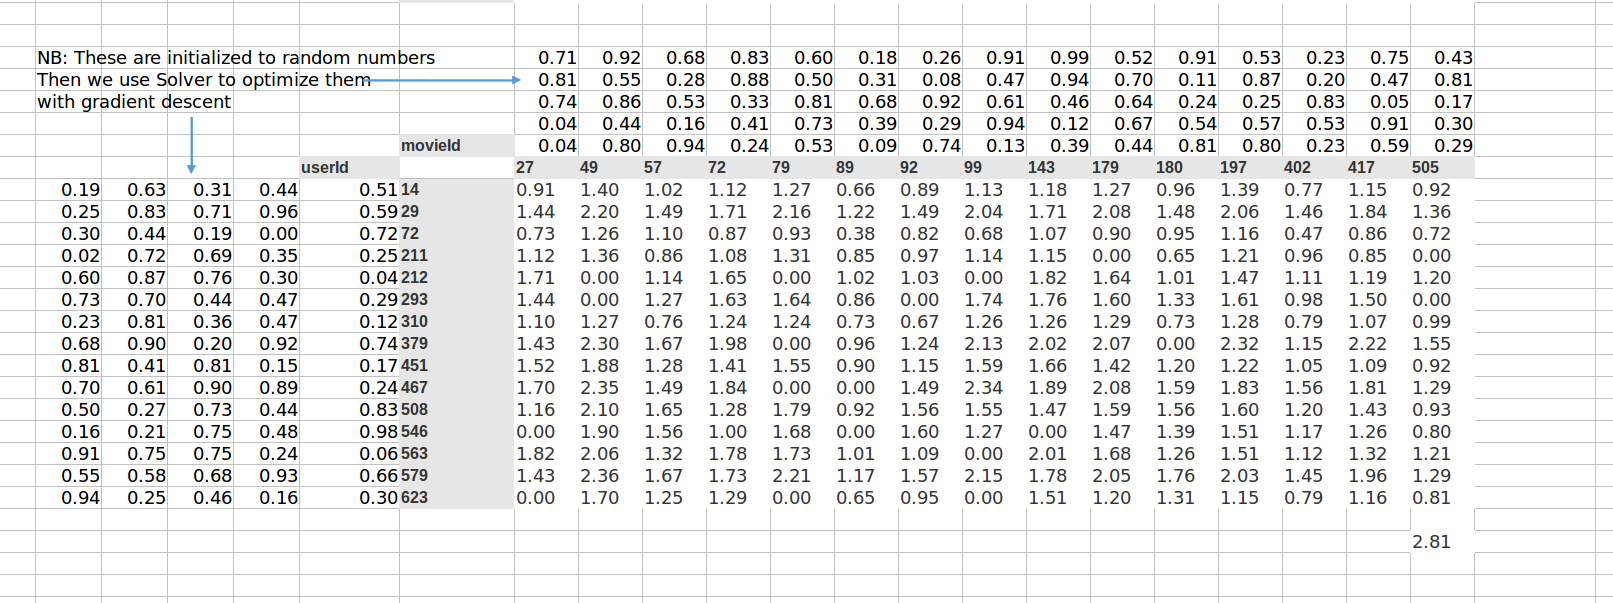

In [6]:
from IPython.display import Image
Image('/home/vinay/Downloads/notebooks/collab.png')

 ## we intutively know that there are some set of features that when once you are given those you know every thing that can be known about it for a given task.......this has been the guiding principle in all of science...we make models with incomplete knowledge(state) of the system that tend to work well for most of the situations(all the laws of physics)....even in other fields on ml like reinforcement learning.........
    
<span class="girk">## SIMPLY WHEN A USER COMES HE WOULD LIKE A MOVIE BASED ON HIS GENERAL TASTE(that's why we are doing dot product) but some movies/users may be generally have uncommon quality...like a really critical user who always gives low rating to movies....we don't want this user to effect the weights(features) ... so we add a bias...</span>
    
    * NOTE:LATER THIS BIAS CAN BE USED FOR INTREPRETATION/SANITY CHECK (WE CAN PLOT THEM ...like look at the bias values of movies and check for the worst movies and SEE WHETHER THEY MAKE SENSE)


In [7]:
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
import os

start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000269


In [8]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [9]:
df.head()

,movie,user,rating,date
9056171,1798,510180,5,1999-11-11
14892677,2866,510180,3,1999-11-11
19585852,3730,510180,4,1999-11-11
20393918,3870,510180,2,1999-11-11
6901473,1367,510180,5,1999-11-11


In [10]:
len(df)

24053764

In [11]:
#minor hack to make it work ...
df = df[['user','movie','rating']]

In [12]:
df.head()

,user,movie,rating
9056171,510180,1798,5
14892677,510180,2866,3
19585852,510180,3730,4
20393918,510180,3870,2
6901473,510180,1367,5


In [13]:
df.columns = ['userId','movieId','ratings']

In [15]:
#let's conv each of the numbers to categorical variadle....note we are using embeddings(just a computationally 
#efficient way of mat-multiply)
series2cat(df, 'userId', 'movieId')
df.head()

,userId,movieId,ratings
9056171,510180,1798,5
14892677,510180,2866,3
19585852,510180,3730,4
20393918,510180,3870,2
6901473,510180,1367,5


In [17]:
learn = get_collab_learner(df, n_factors=50, min_score=0., max_score=5.)
learn.fit_one_cycle(4, 5e-3)   # 0.2% of data set used as validation set...optional test set can also be provided...

A Jupyter Widget

Total time: 5:18:32
epoch  train loss  valid loss
0      1.203497    1.215540    (1:30:45)
1      1.224980    1.215170    (1:20:57)
2      1.161615    1.191800    (1:13:24)
3      1.177166    1.185144    (1:13:24)



* NOTE:A BRIEF LOOK AT GPU UTILIZATION SHOWS ..I AM UNDERUTILIZING IT...I COULD INC BATCH SIZE(DEFAULT = 64)
## It might seem crazy how with almost no code we could get state-of-art results....actually quite so much is going on under the hood for instance the learning rate i have used :5e-3 (it could be found through [lr_finder](https://arxiv.org/abs/1506.01186) as outlined here.).Many other cutting cutting edge research is incorporated all leading to faster and better convergance....basic idea is simple and can be implented without any of these with comparable results....<span class="girk">.i would love to discuss some of the other hacks used under the hood...</span>


In [18]:
learn.save('netflix')